In [1]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))

# Import the volatility analysis library directly
from volatility_pipeline import *

import torch
torch.set_grad_enabled(True)
print(f"Gradients enabled: {torch.is_grad_enabled()}")

Gradients enabled: True


In [ ]:
# Configuration parameters
FETCH_DATA = False  # Set to True to fetch new news data
FROM, TO = "2023-01-01", "2025-12-31"
CUT = "2024-10-01"  # Date to split train/test data
TOPIC = "BUSINESS"
MARKET_NAME = "CAC 40"
WINDOW = 7
EPOCHS = 200
LSTM_TYPE = "simple"  # Options: "improved", "simple"
USE_TECHNICAL_INDICATORS = False

In [3]:
keywords = [
    "cac40",  # French stock index (equivalent to DAX)
    "inflation",  # Inflation (same in French)
    "taux d'intérêt",  # Interest rates
    "tarifs",  # Tariffs
    "croissance économique",  # Economic growth
    "récession",  # Recession
    "chômage",  # Unemployment
    "subventions",  # Subsidies (same in French)
    "investissement",  # Investment
    "expansion"  # Expansion (same in French)
]

KEYWORDS = " OR ".join([f'"{keyword}"' for keyword in keywords])

In [4]:
import pandas as pd, time, random
from pygooglenews import GoogleNews

# Fetch news data function
def fetch_cac_news_data():
    gn = GoogleNews(lang="fr", country="FR")

    all_frames = []

    start_dt = pd.to_datetime(FROM)
    end_dt   = pd.to_datetime(TO)

    while start_dt <= end_dt:
        stop_dt = min(start_dt + pd.Timedelta(days=WINDOW-1), end_dt)

        feed    = gn.search(KEYWORDS,
                            from_=start_dt.strftime("%Y-%m-%d"),
                            to_  =stop_dt.strftime("%Y-%m-%d"))

        df      = pd.DataFrame(
                    {"date":  [pd.to_datetime(e.published).tz_localize(None)
                                for e in feed["entries"]],
                    "title": [e.title for e in feed["entries"]]}
                )
        all_frames.append(df)

        # polite pause to avoid 429 errors
        time.sleep(random.uniform(1.0, 2.5))
        start_dt = stop_dt + pd.Timedelta(days=1)

    news_df = (pd.concat(all_frames, ignore_index=True)
                .drop_duplicates())          # remove overlaps
    
    # Remove the "- name of the news source" suffix from titles
    news_df['title'] = news_df['title'].str.replace(r' - .+$', '', regex=True)
    

    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    news_df.to_csv(f"../news/news_data_{FROM}_{TO}_CAC.csv", index=False)
    
    return news_df

In [5]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_cac_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_CAC.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")

Fetched 12403 news articles


C:\Users\nestor\AppData\Local\Temp\ipykernel_26672\181280578.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  news_df = (pd.concat(all_frames, ignore_index=True)


In [6]:
import yfinance

# Fetch CAC 40 market data using yfinance
cac40 = yfinance.Ticker("^FCHI")
cac40_data = cac40.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
cac40_data = cac40_data.reset_index()  # Convert index to column
cac40_data["Returns"] = cac40_data["Close"].pct_change()
cac40_data["Volatility"] = cac40_data["Returns"].rolling(window=21).std() * np.sqrt(252)
cac40_data = cac40_data.dropna().reset_index(drop=True)

print(f"Loaded {len(cac40_data)} days of CAC 40 market data")
cac40_data.head()

Loaded 591 days of CAC 40 market data


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Volatility
0,2023-01-31 00:00:00+01:00,7075.089844,7088.970215,7025.529785,7082.419922,78055900,0.0,0.0,0.000058,0.126844
1,2023-02-01 00:00:00+01:00,7087.200195,7110.209961,7059.609863,7077.109863,63651600,0.0,0.0,-0.000750,0.127596
2,2023-02-02 00:00:00+01:00,7110.029785,7184.689941,7079.410156,7166.270020,95949900,0.0,0.0,0.012598,0.111226
3,2023-02-03 00:00:00+01:00,7136.399902,7233.939941,7113.419922,7233.939941,89988400,0.0,0.0,0.009443,0.112082
4,2023-02-06 00:00:00+01:00,7181.970215,7187.270020,7104.520020,7137.100098,68293300,0.0,0.0,-0.013387,0.117977


Splitting data at 2024-10-01...
Sentiment model loaded on device: cuda
GPU: NVIDIA GeForce RTX 4070
Calculating enhanced sentiment scores...
Plotting sentiment distribution...


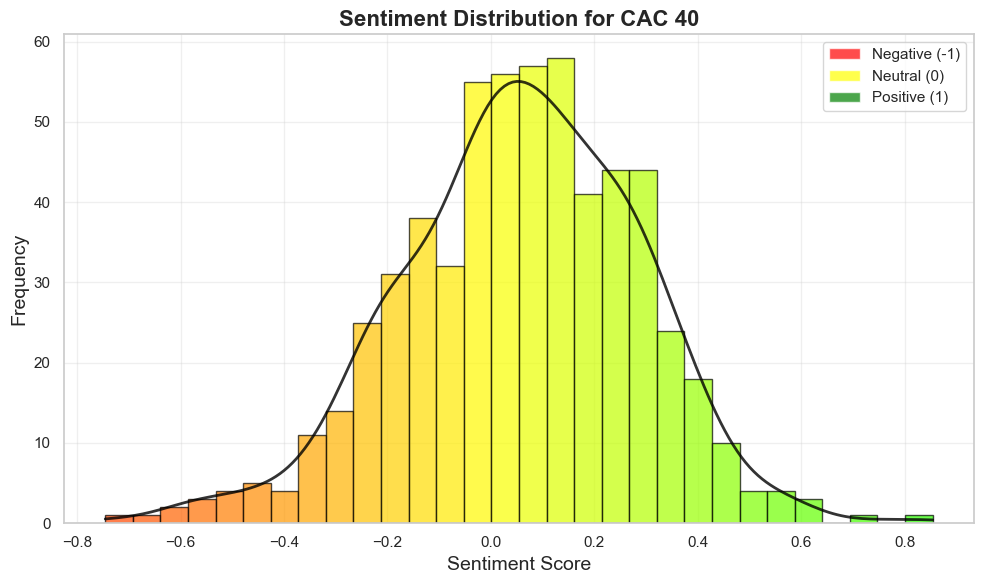

Final feature columns for model: ['Volatility_Smooth', 'news_sentiment_interaction', 'sentiment_mean_3d', 'sentiment_mean_5d', 'sentiment_mean_7d', 'sentiment_lag_2']


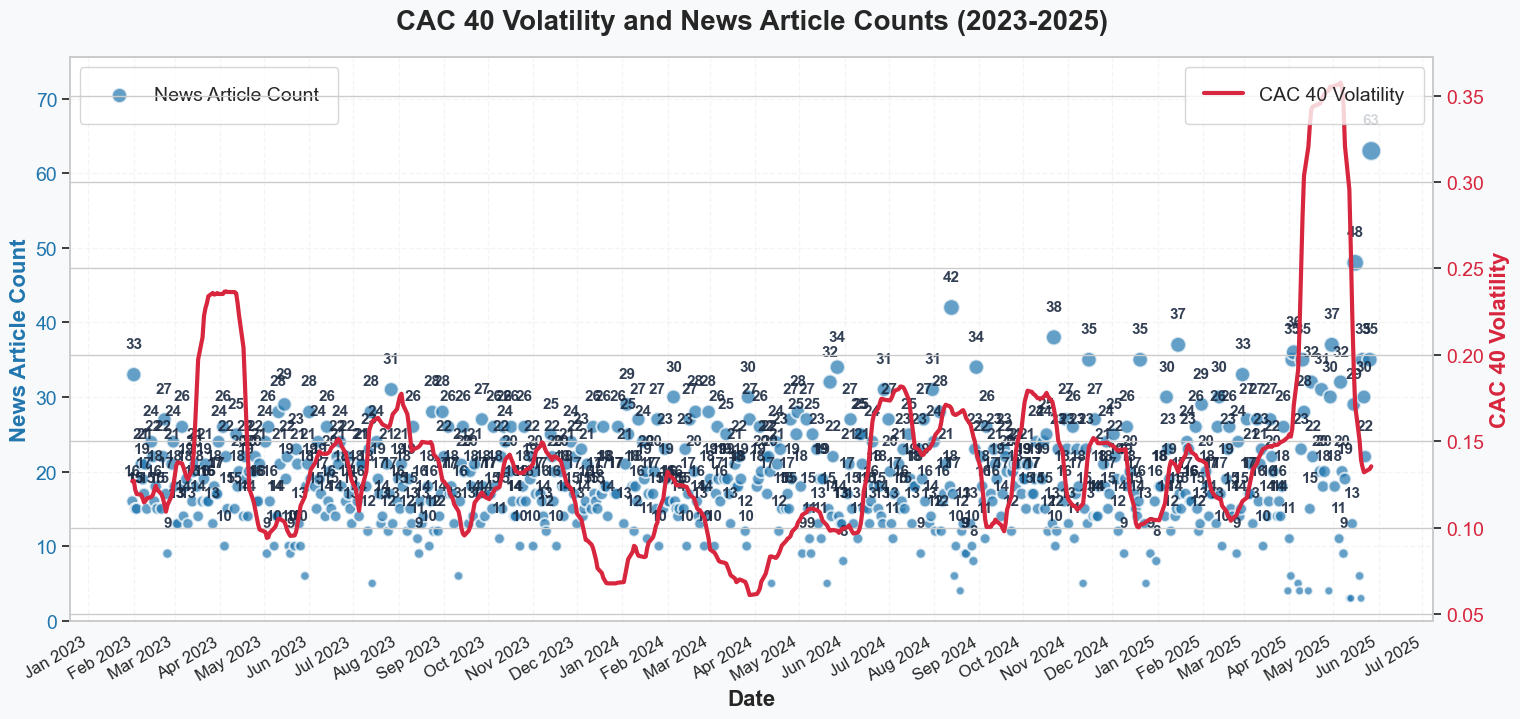

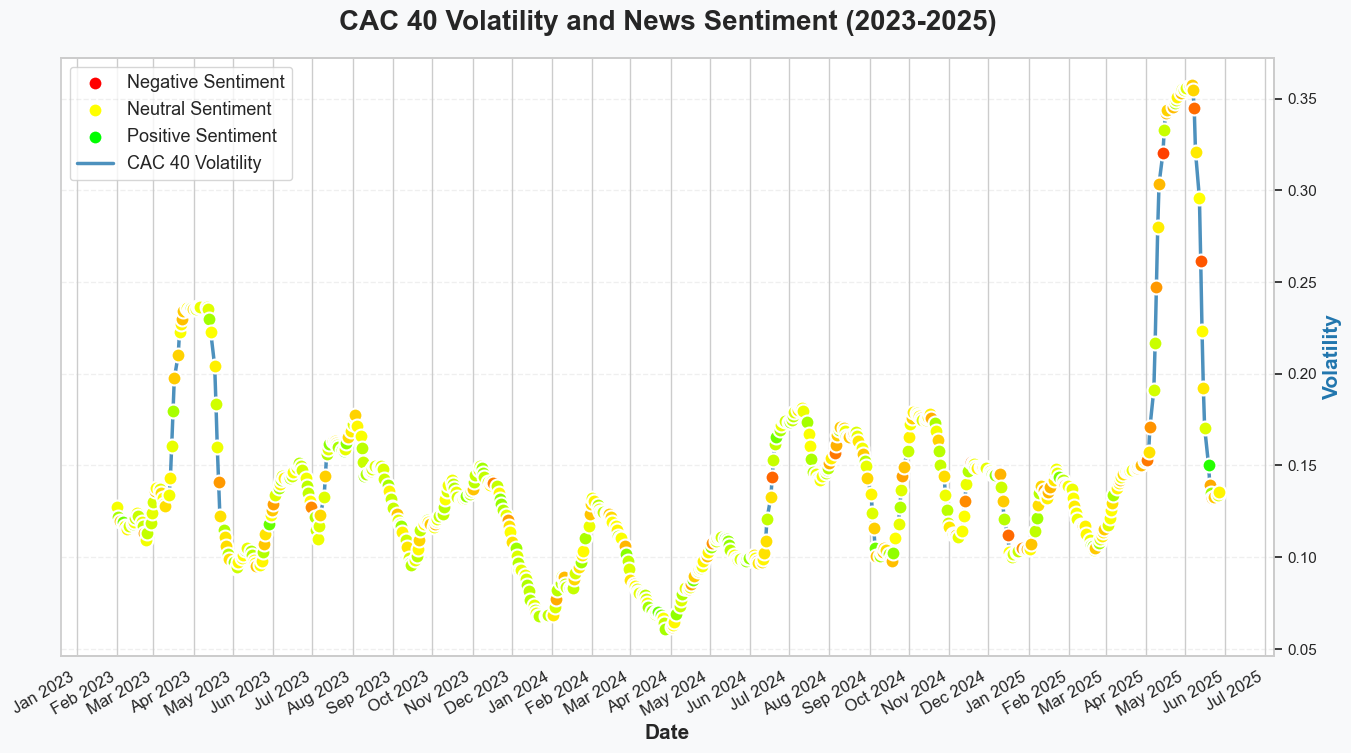

Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Model initialized with 5314 trainable parameters
Epoch 1/200, Train Loss: 0.22775, Val Loss: 0.12530
Epoch 10/200, Train Loss: 0.00684, Val Loss: 0.00553
Epoch 20/200, Train Loss: 0.00518, Val Loss: 0.00426
Epoch 30/200, Train Loss: 0.00402, Val Loss: 0.00332
Epoch 40/200, Train Loss: 0.00288, Val Loss: 0.00245
Epoch 50/200, Train Loss: 0.00195, Val Loss: 0.00180
Epoch 60/200, Train Loss: 0.00153, Val Loss: 0.00144
Epoch 70/200, Train Loss: 0.00135, Val Loss: 0.00126
Epoch 80/200, Train Loss: 0.00124, Val Loss: 0.00116
Epoch 90/200, Train Loss: 0.00115, Val Loss: 0.00108
Epoch 100/200, Train Loss: 0.00107, Val Loss: 0.00100
Epoch 110/200, Train Loss: 0.00100, Val Loss: 0.00094
Epoch 120/200, Train Loss: 0.00093, Val Loss: 0.00088
Epoch 130/200, Train Loss: 0.00088, Val Loss: 0.00083
Epoch 140/200, Train Loss: 0.00082, Val Loss: 0.00078
Epoch 150/200, Train Loss: 0.00078, Val Loss: 0.00074
Epoch 160/200

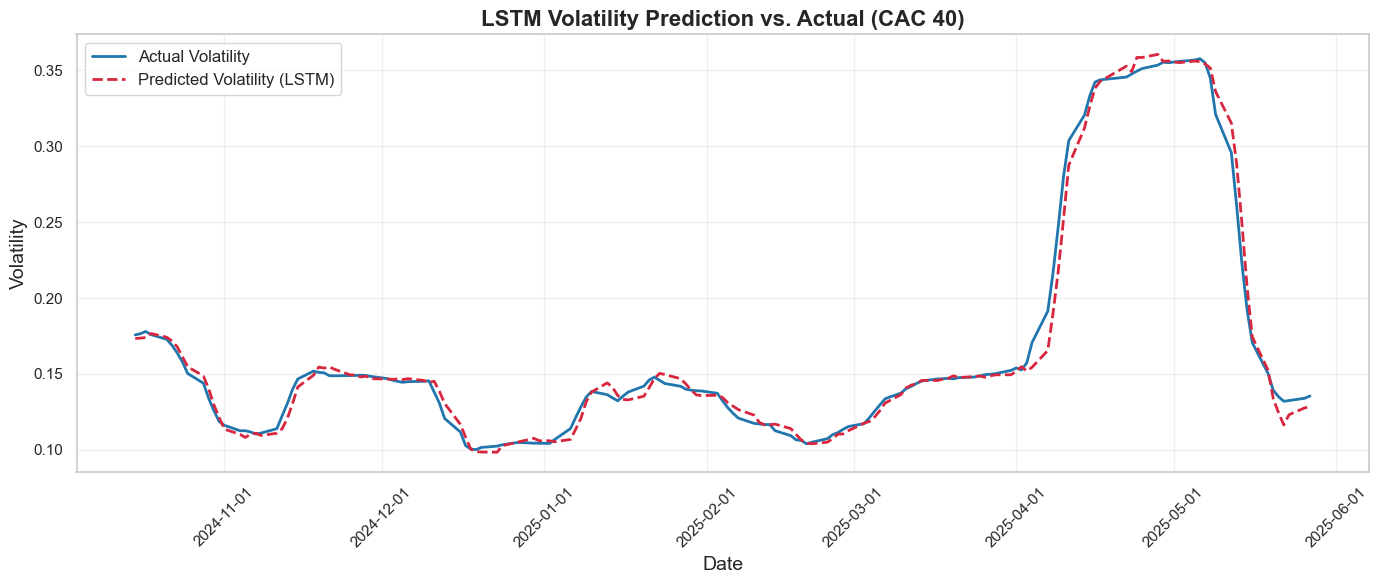

In [7]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=cac40_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=EPOCHS,
    learning_rate=0.001,
    verbose=True,
    use_technical_indicators=USE_TECHNICAL_INDICATORS,
    lstm_type=LSTM_TYPE, 
)

Splitting data at 2024-10-01...
Skipping sentiment calculation (use_sentiment=False)...
Final feature columns for model: ['Volatility_Smooth']
Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Model initialized with 4674 trainable parameters
Epoch 1/200, Train Loss: 0.28284, Val Loss: 0.21951
Epoch 10/200, Train Loss: 0.01608, Val Loss: 0.00798
Epoch 20/200, Train Loss: 0.00909, Val Loss: 0.00642
Epoch 30/200, Train Loss: 0.00588, Val Loss: 0.00456
Epoch 40/200, Train Loss: 0.00323, Val Loss: 0.00268
Epoch 50/200, Train Loss: 0.00277, Val Loss: 0.00231
Epoch 60/200, Train Loss: 0.00245, Val Loss: 0.00202
Epoch 70/200, Train Loss: 0.00218, Val Loss: 0.00177
Epoch 80/200, Train Loss: 0.00194, Val Loss: 0.00156
Epoch 90/200, Train Loss: 0.00172, Val Loss: 0.00136
Epoch 100/200, Train Loss: 0.00152, Val Loss: 0.00119
Epoch 110/200, Train Loss: 0.00137, Val Loss: 0.00103
Epoch 120/200, Train Loss: 0.00127, Val Loss: 0.00091
Epoch 130/200, Train Loss: 0.001

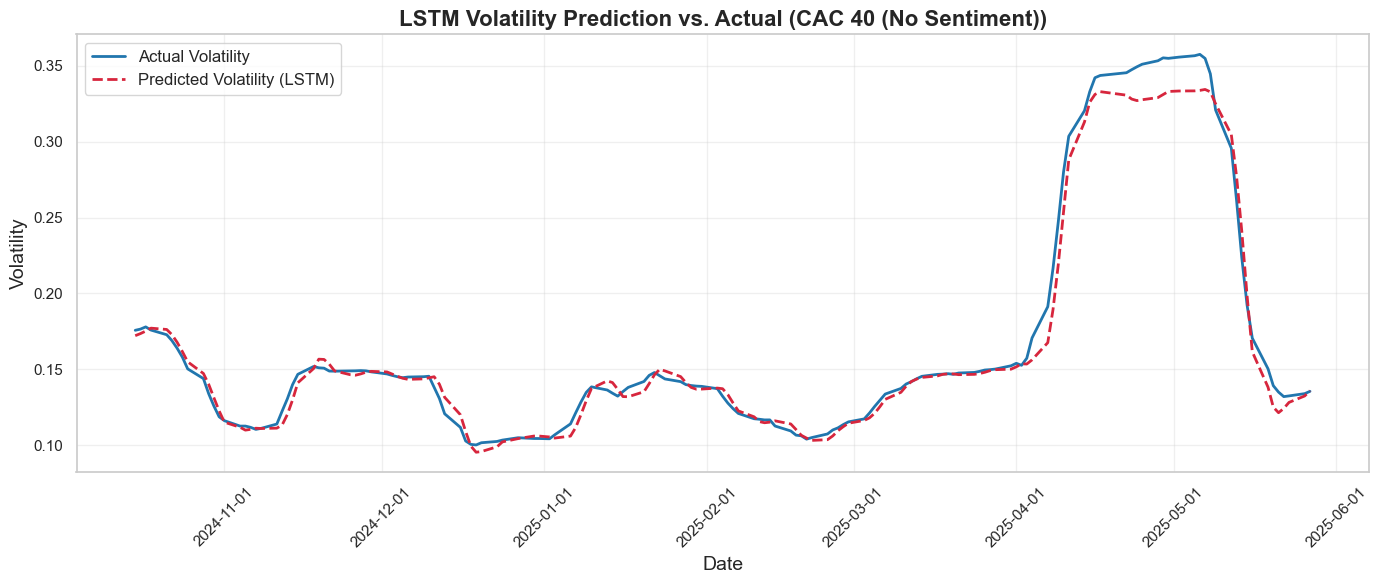

In [8]:
results_no_sentiment = run_volatility_pipeline(
    news_df=news_df,
    stock_data=cac40_data,
    market_name=MARKET_NAME + " (No Sentiment)",
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=EPOCHS,
    learning_rate=0.001,
    use_sentiment=False,
    verbose=True,
    use_technical_indicators=USE_TECHNICAL_INDICATORS,
    lstm_type=LSTM_TYPE,
)

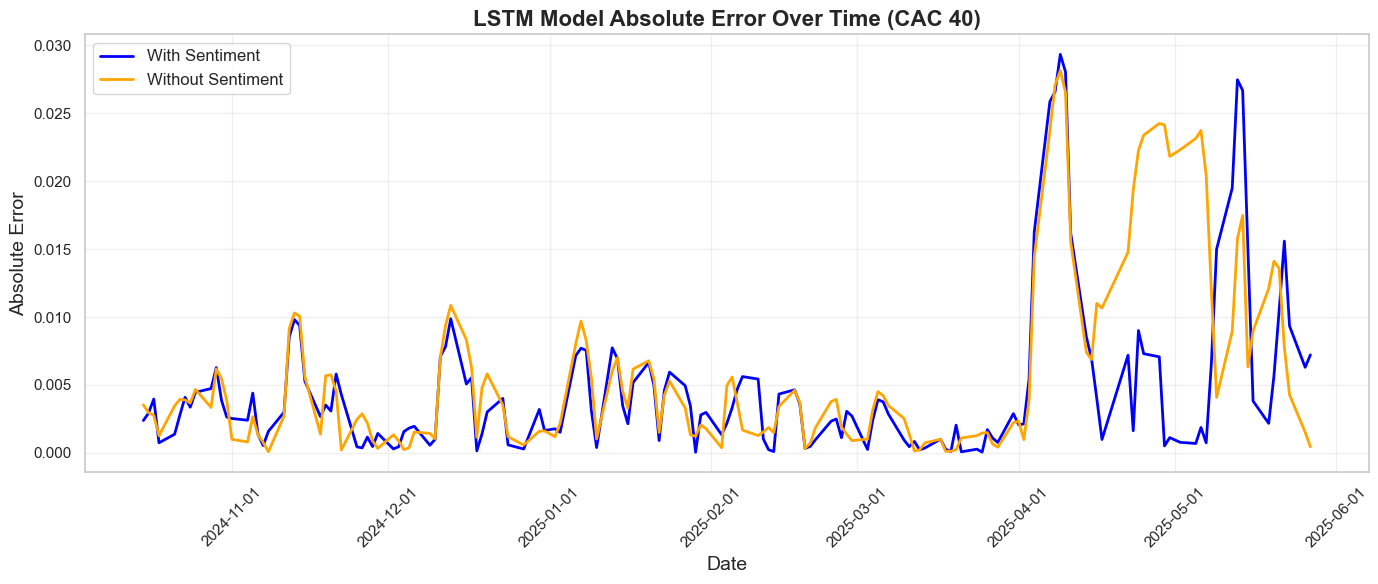

In [9]:
import matplotlib.pyplot as plt
# Plot the MAE over time for both models
plt.figure(figsize=(14, 6))
plt.plot(results['test_dates'], np.abs(results['y_actual'] - results['y_pred']), label='With Sentiment', color='blue', linewidth=2)
plt.plot(results_no_sentiment['test_dates'], np.abs(results_no_sentiment['y_actual'] - results_no_sentiment['y_pred']), label='Without Sentiment', color='orange', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (CAC 40)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Compare metrics between sentiment-based and volatility-only models
print("\n=== MODEL COMPARISON ===")
print("With Sentiment:")
for metric_name, value in results['metrics'].items():
    print(f"  {metric_name}: {value:.6f}")

print("\nWithout Sentiment:")
for metric_name, value in results_no_sentiment['metrics'].items():
    print(f"  {metric_name}: {value:.6f}")


=== MODEL COMPARISON ===
With Sentiment:
  MSE: 0.000055
  RMSE: 0.007432
  MAE: 0.004659
  R2: 0.989340

Without Sentiment:
  MSE: 0.000080
  RMSE: 0.008921
  MAE: 0.005872
  R2: 0.984640
